In [1]:
%%capture
!pip install pyarrow
!pip install awswrangler
!pip install Pyathena
!pip install geopandas
!pip install contextily
!pip install folium
!pip install geojson
!pip install transformers
!pip3 install torch torchvision torchaudio

In [1]:
import torch
import pandas as pd
from transformers import pipeline
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import re
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping
from sklearn.neighbors import KernelDensity
import numpy as np

In [ ]:
%%time
shapefile_path = "LSOA_2011_London_gen_MHW.shp"
#shapefile_path = "PostalArea.shp"
London_wards = gpd.read_file(shapefile_path)

In [ ]:
x = pd.read_parquet('s3://ds-intern-vlad-817187305846-eu-west-1/tdl_test/full_data_1_PPSM.parquet')
#x = pd.read_parquet('s3://ds-intern-vlad-817187305846-eu-west-1/tdl_test/full_data_1.parquet')

geometry = [Point(xy) for xy in zip(x['longitude'], x['latitude'])]
test = gpd.GeoDataFrame(x, geometry = geometry)#gpd.points_from_xy(x.longitude, x.latitude))
test = GeoDataFrame(test, geometry='geometry')#, crs = 3395)
test = test.set_crs("EPSG:4326")

(array([3971., 8677., 3647., 1405.,  465.,  291.,  123.,   61.,   27.,
          31.]),
 array([ 12. ,  60.3, 108.6, 156.9, 205.2, 253.5, 301.8, 350.1, 398.4,
        446.7, 495. ]),
 <BarContainer object of 10 artists>)

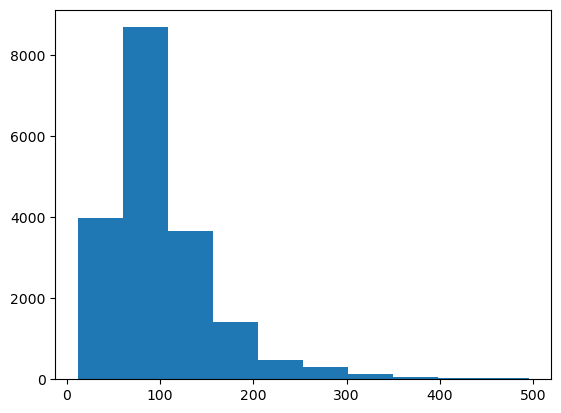

In [20]:
plt.hist(x.dropna()['property_floor_area'])

In [27]:
x = x.drop_duplicates(subset=['short_description'],keep='first')

In [6]:
x = x.drop(columns=['long_description', 'bullets','price_band'])

In [ ]:
df = pd.read_csv('London_Neighbourhoods.csv')
df = df.drop(df.iloc[:, 6:11], axis =1)
df = pd.DataFrame(df)
# this removes all the values within brackets
df['Location'] = df['Location'].str.replace(r"\(.*\)","", regex = True)
def remove_text_inside_brackets(text, brackets="()[]"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)

df['Location'][453] = remove_text_inside_brackets(df['Location'][453])
# this removes all leading/trailing white spaces
df['Location'] = df['Location'].str.strip()

In [ ]:
df['Location'][453]

In [ ]:
full_neigh = df.Location.to_list()

In [ ]:
borough_neighborhoods = {}
for index, row in df.iterrows():
    location = row['Location']
    boroughs = row['London borough'].split(',')

    for borough in boroughs:
        borough = borough.strip()  # Remove any leading/trailing spaces
        if borough not in borough_neighborhoods:
            borough_neighborhoods[borough] = []
        borough_neighborhoods[borough].append(location)

for borough, neighborhoods in borough_neighborhoods.items():
    borough_neighborhoods[borough] = sorted(neighborhoods)

In [ ]:
# now subsetting the data to individual boroughs

# Create a dictionary to store borough names and their corresponding dataframes
borough_dataframes = {}

# Loop through the unique boroughs in the "listing_local_authority" column
for borough in test['listing_local_authority'].unique():
    # Create a subset dataframe for the current borough
    subset_df = test[test['listing_local_authority'] == borough].copy()
    
    # Add the subset dataframe to the dictionary with the borough name as the key
    borough_dataframes[borough] = subset_df.reset_index()

# Now, the 'borough_dataframes' dictionary contains borough names as keys and their corresponding dataframes as values
# You can access the dataframes for each borough directly from the dictionary


In [ ]:
# Get the common keys between the two dictionaries
common_keys = set(borough_neighborhoods.keys()).intersection(borough_dataframes.keys())
common_keys = sorted(list(common_keys))

In [34]:
# Read Parquet files from S3 and concatenate them
dfs = []
for common_keys in common_keys:
    df = pd.read_csv(f"s3://ds-intern-vlad-817187305846-eu-west-1/data/KDE_full_results_v2/{common_keys}_result.csv")
    dfs.append(df)

# Concatenate DataFrames
merged_df = pd.concat(dfs, ignore_index=True)
# totals nearly 40k rows

In [35]:
merged_df = merged_df.drop_duplicates(subset=['String'], keep='first')
test=test.drop_duplicates(subset=['short_description'],keep='first')

In [36]:
KDE_FINAL = pd.merge(merged_df, test, left_on='String', right_on='short_description', how='left')

In [37]:
KDE_FINAL = KDE_FINAL.drop(columns=['long_description'])

In [54]:
#KDE_FINAL.read_csv('s3://ds-intern-vlad-817187305846-eu-west-1/data/model_results_full/KDE_full_results.csv')

In [38]:
KDE_FINAL['Labels'] = KDE_FINAL['Labels'].astype('string')
#prout = prout.drop(columns =['Unnamed: 0'])
from shapely import wkt
KDE_FINAL['geometry'] = KDE_FINAL['geometry_y']#.apply(wkt.loads)
KDE_FINAL = gpd.GeoDataFrame(KDE_FINAL, #crs='epsg:27700') # 
                         crs='epsg:4326')

In [39]:
%%time
new_dfs = {}

test2 = KDE_FINAL[['String','Labels','geometry','Scores']]#, 'latitude', 'longitude']]

test2['latitude'] = test2.geometry.y
test2['longitude'] = test2.geometry.x

# Iterate over the word list
for word in full_neigh:
    # Subset the DataFrame for the current word
    subset_df = test2[test2['Labels'].str.contains(word)]
    # Store the subset DataFrame in the dictionary
    new_dfs[word] = subset_df
    
filtered_dict = {k: v for (k, v) in new_dfs.items() if len(v) > 10} 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 5.7 s, sys: 0 ns, total: 5.7 s
Wall time: 5.7 s


In [40]:
del filtered_dict['Tooting']

CPU times: user 31.4 s, sys: 29.1 ms, total: 31.5 s
Wall time: 32 s


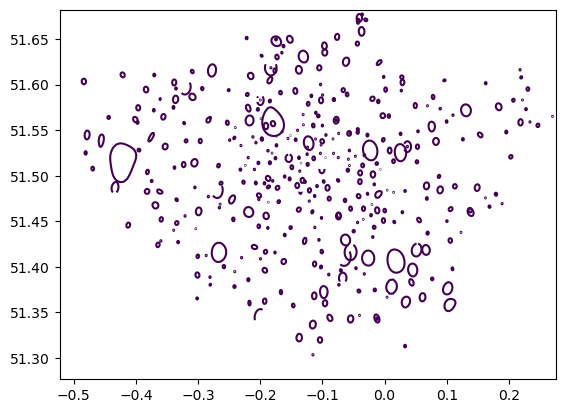

In [20]:
%%time

m = folium.Map(location=[51.6,0], zoom_start=10)

# Define the bandwidth for KDE
bandwidth = 0.01
boundary_gdf = gpd.GeoDataFrame(columns=['cluster_label', 'geometry'])
# Loop through the dictionary of DataFrames
for df_name, df in filtered_dict.items():
    #empty dataframe for polygon storage
    polygons = []
    # Create an empty feature group for the KDE contour
    kde_fg = folium.FeatureGroup(name=df_name, show=False, tooltip=df_name)

    #df['latitude'] = df.geometry.y
    #df['longitude'] = df.geometry.x
    # Extract the latitude and longitude values
    data = df[['latitude', 'longitude']].dropna().values

    # Fit the KDE model
    kde = KernelDensity(bandwidth = bandwidth)
    kde.fit(data)

    # Generate grid points for evaluation
    lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
    lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
    lat_grid, lon_grid = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
    grid_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    # Evaluate the KDE on grid points
    log_density = kde.score_samples(grid_points)

    # Convert log density to probability density
    density = np.exp(log_density)
    # Reshape density to match grid shape
    density = density.reshape(lat_grid.shape)

    # Find contours of high density regions
    contours = plt.contour(lon_grid, lat_grid, density, levels=[np.percentile(density, 99)])

    # Loop through the contour paths and create polygons
    for path in contours.collections[0].get_paths():
        polygon = Polygon(path.vertices)
        polygons.append(polygon)
        
        # Create a GeoDataFrame from the polygon
        gdf = gpd.GeoDataFrame(geometry=[polygon])
        
        # Set the CRS to WGS84
        gdf.crs = "EPSG:4326"

        # Convert the GeoDataFrame to GeoJSON
        geojson = gdf.to_json()

        # Create a folium GeoJson object from the GeoJSON
        geojson_obj = folium.GeoJson(geojson, name=df_name, show=False, tooltip=df_name)

        # Add the GeoJson object to the KDE feature group
        geojson_obj.add_to(kde_fg)
    
    poly = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
    poly['cluster_label'] = df_name
    
    # Add the GeoDataFrame to the list
    boundary_gdf = pd.concat([boundary_gdf, poly], ignore_index = True)
    
    # Add the KDE feature group to the map
    kde_fg.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m);

In [59]:
kde.bandwidth_

0.01

In [21]:
m

In [22]:
London_wards=London_wards.to_crs("EPSG:4326")
boundary_gdf=boundary_gdf.to_crs("EPSG:4326")

In [23]:
import geopandas as gpd

# Load the shapefiles
postcodes_gdf = London_wards

# Create a dictionary to store overlapping postcodes for each boundary
overlapping_postcodes = {}

# Iterate through each boundary
for index, boundary_row in boundary_gdf.iterrows():
    boundary = boundary_row['geometry']
    boundary_label = boundary_row['cluster_label']
    
    # Find overlapping postcodes
    overlapping = postcodes_gdf[postcodes_gdf['geometry'].intersects(boundary)]
    overlapping_postcodes[boundary_label] = overlapping['LSOA11NM'].tolist()

# Create a new GeoDataFrame to store the results
overlap_data = {'cluster_label': [], 'overlapping_postcodes': []}
for boundary_label, postcodes_list in overlapping_postcodes.items():
    overlap_data['cluster_label'].append(boundary_label)
    overlap_data['overlapping_postcodes'].append(postcodes_list)

overlap_gdf = gpd.GeoDataFrame(overlap_data, geometry=boundary_gdf['geometry'], crs="EPSG:4326")

# Save the GeoDataFrame with overlapping postcodes
#overlap_gdf.to_file('overlapping_postcodes_with_boundaries.shp')

In [24]:
from shapely.ops import cascaded_union

# Merge overlapping geometries into a single polygon per cluster
merged_geometries = []
for index, row in overlap_gdf.iterrows():
    cluster_label = row['cluster_label']
    overlapping_postcodes = row['overlapping_postcodes']
    
    # Select geometries of overlapping postcodes
    selected_geometries = postcodes_gdf[postcodes_gdf['LSOA11NM'].isin(overlapping_postcodes)]['geometry']
    
    # Merge the selected geometries into a single polygon
    merged_geometry = selected_geometries.unary_union
    
    # Append to the list of merged geometries
    merged_geometries.append((cluster_label, merged_geometry))

# Create a GeoDataFrame with merged geometries
merged_gdf = gpd.GeoDataFrame(merged_geometries, columns=['cluster_label', 'geometry'], crs="EPSG:4326")

In [25]:
# Create a Folium map centered on the merged geometries
m = folium.Map([51.47,0.08], zoom_start=12)

# Iterate through the merged geometries and add them to the map
for index, row in merged_gdf.iterrows():
    cluster_label = row['cluster_label']
    geometry = row['geometry']
    
    # Convert geometry to GeoJSON
    geojson = geometry.__geo_interface__
    
    # Create a Folium GeoJson object from the GeoJSON
    folium.GeoJson(geojson,
                   name=cluster_label,
                   style_function=lambda feature: {'fillColor': 'red', 'color': 'none', 'fillOpacity': 0.6},  # Change colors as needed
                   highlight_function=lambda feature: {'fillColor': 'blue', 'color': 'none', 'fillOpacity': 0.6},  # Change highlight colors as needed
                   tooltip=cluster_label,  # Show cluster_label as tooltip
                   show = False
                  ).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)
m

In [27]:
#m.save('KDE_boundaries_V1.html')

In [89]:
validation_attempt = KDE_FINAL[['Labels','geometry','price', 'property_floor_area', 'search_clicks', 'price_band']]

In [90]:
# Define a function to remove square brackets from a label
def remove_brackets(label):
    return label.strip('[]')

# Apply the function to the 'Labels' column
validation_attempt['Labels'] = validation_attempt['Labels'].apply(remove_brackets)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [94]:
%%time
# Function to split values separated by commas into separate rows
def split_labels(row):
    labels = row['Labels'].split(', ')
    return pd.Series(labels)

# Apply the split_labels function to each row and stack the results
new_df = validation_attempt.apply(split_labels, axis=1).stack().reset_index(level=1, drop=True).reset_index()
new_df.columns = ['Original Index', 'Labels']

CPU times: user 6.65 s, sys: 32 ms, total: 6.68 s
Wall time: 6.66 s


In [95]:
new = pd.merge(validation_attempt, new_df, left_index=True, right_on='Original Index', how='left')

new = new[['Labels_y', 'geometry','price', 'property_floor_area', 'search_clicks','price_band']]
new['Labels_y'] = new['Labels_y'].str.replace("'", '')

Labels_y                   geometry      price  \
0            'Dagenham'   POINT (0.15368 51.53903)   375000.0   
1          'Marks Gate'   POINT (0.13723 51.58438)   465000.0   
2      'Chadwell Heath'   POINT (0.15368 51.53903)   400000.0   
3            'Dagenham'   POINT (0.15368 51.53903)   400000.0   
4            'Dagenham'   POINT (0.15028 51.55870)   365000.0   
...                 ...                        ...        ...   
31053   'Covent Garden'  POINT (-0.12687 51.51139)  1025000.0   
31054     'Westminster'  POINT (-0.12622 51.49732)  1700000.0   
31055        'Millbank'  POINT (-0.12622 51.49732)  1700000.0   
31056      'Maida Vale'  POINT (-0.17806 51.52513)   825000.0   
31057         'Pimlico'  POINT (-0.14675 51.48892)   670000.0   

       property_floor_area  search_clicks             price_band  
0                     84.0            3.0    £250,001 - £375,000  
1                     93.0            3.0    £375,001 - £500,000  
2                     84.0            3.0    £375,001 - £500,000  
3                     84.0            3.0    £375,001 - £500,000  
4                     76.0            6.0    £250,001 - £375,000  
...                    ...            ...                    ...  
31053                 89.0            0.0  £925,001 - £1,500,000  
31054                  NaN            1.0    £1,500,000 and over  
31055                  NaN            1.0    £1,500,000 and over  
31056                 73.0            0.0    £700,001 - £925,000  
31057                  NaN            0.0    £500,001 - £700,000  

[31058 rows x 6 columns]

In [97]:
new = new.dropna()

In [98]:
# Count the occurrences of each label
label_counts = new['Labels_y'].value_counts()

# Create a list of labels that appear more than 10 times
labels_to_keep = label_counts[label_counts > 10].index.tolist()

# Subset the DataFrame to keep only the selected labels
new = new[new['Labels_y'].isin(labels_to_keep)]

In [99]:
new = new.reset_index()

In [100]:
new['Labels_y'] = new['Labels_y'].str.replace('(also Lower Sydenham,\\nUpper Sydenham)','')

In [52]:
new.Labels_y.nunique()

352

In [75]:
new['PPSM'] = new['price']/new['property_floor_area']

In [76]:
new

index         Labels_y                   geometry      price  \
0          0         Dagenham   POINT (0.15368 51.53903)   375000.0   
1          2   Chadwell Heath   POINT (0.15368 51.53903)   400000.0   
2          3         Dagenham   POINT (0.15368 51.53903)   400000.0   
3          4         Dagenham   POINT (0.15028 51.55870)   365000.0   
4          5         Dagenham   POINT (0.14269 51.54671)   370000.0   
...      ...              ...                        ...        ...   
26530  31049       Maida Vale  POINT (-0.18356 51.53067)   400000.0   
26531  31050        Belgravia  POINT (-0.15554 51.49637)  2450000.0   
26532  31051  "St Johns Wood"  POINT (-0.17398 51.52798)  1300000.0   
26533  31053    Covent Garden  POINT (-0.12687 51.51139)  1025000.0   
26534  31056       Maida Vale  POINT (-0.17806 51.52513)   825000.0   

       property_floor_area          PPSM  
0                     84.0   4464.285714  
1                     84.0   4761.904762  
2                     84.0   4761.904762  
3                     76.0   4802.631579  
4                     72.0   5138.888889  
...                    ...           ...  
26530                 40.0  10000.000000  
26531                139.0  17625.899281  
26532                 90.0  14444.444444  
26533                 89.0  11516.853933  
26534                 73.0  11301.369863  

[26535 rows x 6 columns]

In [54]:
%%time
# Get unique label clusters
label_clusters = new['Labels_y'].unique()

# Create an empty DataFrame to store correlation results
correlation_results = pd.DataFrame(index=label_clusters, columns=label_clusters)

# Calculate correlations between label clusters
for label1 in label_clusters:
    for label2 in label_clusters:
        if label1 != label2:
            cluster1 = new[new['Labels_y'] == label1]
            cluster2 = new[new['Labels_y'] == label2]
            correlation = cluster1['search_clicks'].corr(cluster2['search_clicks'])
            correlation_results.at[label1, label2] = correlation

KeyboardInterrupt: 

In [125]:
close_boundaries = gpd.GeoDataFrame(boundary_gdf, geometry=gpd.GeoSeries([new[new['Labels_y'] == label]['geometry'].unary_union for label in new.Labels_y.unique()]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collecti

In [130]:
close_boundaries[close_boundaries.cluster_label == 'Dagenham']

cluster_label                                           geometry
88      Dagenham  MULTIPOINT (-0.04731 51.34697, -0.04728 51.347...

In [104]:
# this removes the null geometries
new = new[~new['geometry'].is_empty]
new = new.reset_index()
#new = new.drop(columns = ['index','level_0'])

In [102]:
new.price_band = pd.Categorical(new.price_band)
new['price_band'] = new.price_band.cat.codes
new

index         Labels_y                   geometry      price  \
0          0         Dagenham   POINT (0.15368 51.53903)   375000.0   
1          2   Chadwell Heath   POINT (0.15368 51.53903)   400000.0   
2          3         Dagenham   POINT (0.15368 51.53903)   400000.0   
3          4         Dagenham   POINT (0.15028 51.55870)   365000.0   
4          5         Dagenham   POINT (0.14269 51.54671)   370000.0   
...      ...              ...                        ...        ...   
26327  31049       Maida Vale  POINT (-0.18356 51.53067)   400000.0   
26328  31050        Belgravia  POINT (-0.15554 51.49637)  2450000.0   
26329  31051  "St Johns Wood"  POINT (-0.17398 51.52798)  1300000.0   
26330  31053    Covent Garden  POINT (-0.12687 51.51139)  1025000.0   
26331  31056       Maida Vale  POINT (-0.17806 51.52513)   825000.0   

       property_floor_area  search_clicks  price_band  
0                     84.0            3.0           3  
1                     84.0            3.0           4  
2                     84.0            3.0           4  
3                     76.0            6.0           3  
4                     72.0            0.0           3  
...                    ...            ...         ...  
26327                 40.0            1.0           4  
26328                139.0            0.0           0  
26329                 90.0            0.0           7  
26330                 89.0            0.0           7  
26331                 73.0            0.0           6  

[26332 rows x 7 columns]

In [122]:
%%time
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

# Load your GeoDataFrame with property data (replace with your own dataset)
# For demonstration, let's assume you have a GeoDataFrame named 'property_gdf'.
# Ensure it contains a 'geometry' column with Point geometries.
# Also, load your boundary_gdf as you have it.

# Create a function to calculate cluster statistics
def calculate_cluster_statistics(geodf, clusters):
    cluster_stats = []
    for cluster_id in np.unique(clusters):
        cluster_data = geodf[clusters == cluster_id]
        mean_price = cluster_data['property_floor_area'].mean()
        var_price = cluster_data['property_floor_area'].var()
        cluster_stats.append((cluster_id, mean_price, var_price))
    return pd.DataFrame(cluster_stats, columns=['Cluster', 'Mean area', 'Variance area'])

# Calculate pairwise distances between properties based on geographical coordinates
distances = pairwise_distances(new['geometry'].apply(lambda geom: (geom.x, geom.y)).values.tolist())

CPU times: user 6.29 s, sys: 2.02 s, total: 8.31 s
Wall time: 4.28 s


In [59]:
%%time
# Set the number of control clusters (adjust as needed)
num_control_clusters = new.Labels_y.nunique()

# Create control clusters based on K-Means clustering of pairwise distances
control_clusters = KMeans(n_clusters=num_control_clusters, random_state=0).fit_predict(distances)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: user 1h 37min 4s, sys: 1min 56s, total: 1h 39min
Wall time: 25min 24s


In [123]:
%%time
# Calculate statistics for actual boundaries and control clusters
actual_stats = calculate_cluster_statistics(new, new['Labels_y'])
control_stats = calculate_cluster_statistics(new, control_clusters)

CPU times: user 2.18 s, sys: 0 ns, total: 2.18 s
Wall time: 2.18 s


In [124]:

# Merge on a common identifier, such as 'Cluster'
#merged_stats = pd.merge(actual_stats, control_stats, on='Cluster', suffixes=('_Actual', '_Control'))

# Now, concatenate the merged DataFrame with your boundary_gdf or any other relevant data
final_result = pd.concat([actual_stats, control_stats], axis=1)

In [116]:
final_result.to_csv('validation_attempt_v2_band.csv')

In [62]:
final_result.to_csv('validation_attempt_v2_clicks.csv')

In [85]:
final_result.to_csv('validation_attempt_v2_PPSM.csv')

In [21]:
x = pd.read_csv('validation_attempt_v2_PPSM.csv')

In [125]:
final_result['Mean_area'] = final_result.iloc[:, 1]
final_result['Mean area 1'] = final_result.iloc[:, 4]

In [126]:
final_result

Cluster   Mean area  Variance area  Cluster   Mean area  \
0       "Kings Cross"   79.311111     854.628283        0  126.976190   
1       "Queens Park"  124.436364    4463.213468        1   90.716667   
2    "Shepherds Bush"  118.076923    4513.113846        2  202.503185   
3     "Shooters Hill"   92.071429     745.677700        3   75.395349   
4         "St Jamess"  129.666667    5709.666667        4   78.382716   
..                ...         ...            ...      ...         ...   
347          Woodside   74.600000     428.828571      347   87.692308   
348     Woodside Park  123.500000    6957.500000      348   73.420000   
349          Woolwich   77.853503     600.613016      349  124.059603   
350    Worcester Park  119.317647    2620.481232      350   80.561404   
351           Yeading   79.090909    2004.690909      351   80.232143   

     Variance area   Mean_area  Mean area 1  
0      3572.240390   79.311111   126.976190  
1      2080.918362  124.436364    90.716667  
2     11179.879797  118.076923   202.503185  
3       732.971272   92.071429    75.395349  
4      1387.514198  129.666667    78.382716  
..             ...         ...          ...  
347     976.099548   74.600000    87.692308  
348     539.677143  123.500000    73.420000  
349    6698.203091   77.853503   124.059603  
350     807.500627  119.317647    80.561404  
351    1407.490584   79.090909    80.232143  

[352 rows x 8 columns]

In [63]:
!pip install spicy

In [64]:
import spicy

In [24]:
from spicy import stats

ne_lst = list(x.dropna()['Mean Price'])
w_lst = list(x.dropna()['Mean Price.1'])

# Run two sample t-test
# Assumes equal variance. You can also set `equal_var = False`
# In that case, the function will run a Welch's t-test
stats.ttest_ind(ne_lst, w_lst)

TtestResult(statistic=2.33707146058514, pvalue=0.019714910386382373, df=704.0)

In [88]:
from spicy import stats

ne_lst = list(final_result.dropna()['Mean_clicks'])
w_lst = list(final_result.dropna()['Mean clicks 1'])

# Run two sample t-test
# Assumes equal variance. You can also set `equal_var = False`
# In that case, the function will run a Welch's t-test
stats.ttest_ind(ne_lst, w_lst)

TtestResult(statistic=0.3911153795955277, pvalue=0.6958306285989553, df=702.0)

In [121]:
from spicy import stats

ne_lst = list(final_result.dropna()['Mean_band'])
w_lst = list(final_result.dropna()['Mean band 1'])

# Run two sample t-test
# Assumes equal variance. You can also set `equal_var = False`
# In that case, the function will run a Welch's t-test
stats.ttest_ind(ne_lst, w_lst, equal_var=False)

TtestResult(statistic=0.017029911567509513, pvalue=0.986417678939171, df=689.6193679822454)

In [127]:
from spicy import stats

ne_lst = list(final_result.dropna()['Mean_area'])
w_lst = list(final_result.dropna()['Mean area 1'])

# Run two sample t-test
# Assumes equal variance. You can also set `equal_var = False`
# In that case, the function will run a Welch's t-test
stats.ttest_ind(ne_lst, w_lst, equal_var=False)

TtestResult(statistic=-0.5634314923881103, pvalue=0.5733213589175148, df=700.6774671889591)

(array([217.,  82.,  28.,  11.,   7.,   3.,   2.,   1.,   1.,   1.]),
 array([ 3792.03459618,  6751.69252441,  9711.35045264, 12671.00838088,
        15630.66630911, 18590.32423735, 21549.98216558, 24509.64009381,
        27469.29802205, 30428.95595028, 33388.61387852]),
 <BarContainer object of 10 artists>)

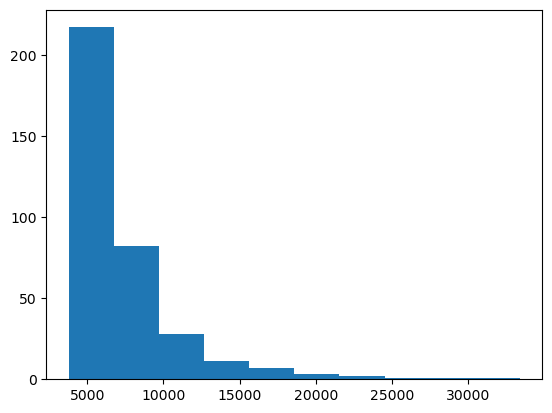

In [14]:
plt.hist(x.dropna()['Mean Price'])

In [20]:
x['Variance Price.1'].mean()

990867420578.3417

In [22]:
x['Variance Price'].mean()

1105037514932.0596

In [26]:
x#['Mean Price'].mean()

Unnamed: 0           Cluster    Mean Price  Variance Price  Cluster.1  \
0             0     "Kings Cross"  8.693271e+05    1.740010e+11          0   
1             1     "Queens Park"  1.504307e+06    1.002586e+12          1   
2             2  "Shepherds Bush"  1.070450e+06    4.821718e+11          2   
3             3   "Shooters Hill"  4.390957e+05    2.488354e+10          3   
4             4       "St Jamess"  4.138500e+06    1.861805e+13          4   
..          ...               ...           ...             ...        ...   
360         360          Woodside  3.080382e+05    6.752506e+09        360   
361         361     Woodside Park  8.090864e+05    3.351706e+11        361   
362         362          Woolwich  3.715317e+05    1.790515e+10        362   
363         363    Worcester Park  6.406974e+05    4.342775e+10        363   
364         364           Yeading  3.463500e+05    4.065625e+10        364   

     Mean Price.1  Variance Price.1  
0    4.499573e+05      3.082325e+10  
1    5.472997e+05      3.300014e+10  
2    3.205090e+06      2.118087e+13  
3    3.047602e+05      1.200855e+10  
4    5.994397e+05      3.199408e+10  
..            ...               ...  
360  8.217174e+05      3.631067e+11  
361  4.486154e+05      2.648969e+10  
362  9.317500e+05      5.661329e+11  
363  6.367795e+05      1.966875e+11  
364  5.793424e+05      8.257705e+10  

[365 rows x 7 columns]

In [128]:
control_clusters.to_

array([  3,   3,   3, ..., 349, 189, 349], dtype=int32)